# **Распознавание темы текста: Базовые алгоритмы и генерация текста с использованием LSTM**

## **Постановка проблемы:**

### **Распознавание темы текста** — это важная задача в области обработки естественного языка (NLP), которая может рассматриваться со стороны классификации по заранее определённым категориям, так и со стороны генерации заголовка проналазированного текста.

###Существует несколько подходов к решению этой задачи.

#### Для **классификации текста** использовались базовые алгоритмы машинного обучения - **Random Forest(RF)** и **K-Nearest Neighbors(k-NN)**.

#### Для **генерации заголовка** использовались рекуррентные нейронные сети - **Long Short-Term Memory(LSTM)** и **Gated Recurrent Unit(GRU)**.

# **Цель работы:**

* Разработка модели классификации текста с использованием базовых алгоритмов машинного обучения, таких как **Random Forest (RF)** и **K-Nearest Neighbors (k-NN)**, для определения категории текста по заранее определённым меткам.
* Генерация заголовков для текстов с использованием рекуррентных нейронных сетей, таких как **Long Short-Term Memory (LSTM)** и **Gated Recurrent Unit (GRU)**, для создания автоматических заголовков на основе текста.
* Сравнение эффективности методов классификации и генерации текста, чтобы выявить оптимальные подходы в зависимости от характеристик входных данных и поставленных задач.
* Построение и обучение моделей для распознавания темы текста и генерации заголовков, а также проведение экспериментов по оценке качества решений на базе метрик, таких как точность классификации и качество сгенерированных заголовков.


# **Данные для анализа**
## Для анализа был выбран датасет новостных записей AG NEWS: https://huggingface.co/datasets/sh0416/ag_news

### Структура датасета:

* label(int) - Число от 1 до 4, которое означает принадлежность к классу новостей
  1. World - Мировые новости
  2. Sports - Спорт
  3. Business - Бизнес и финансы
  4. Sci/Tech - Наука и технологии

* title - Заголовок текста
* description - Текст

* Объем датасета(строки):
  * Train - 120 000
  * Test - 7 600

* Вес датасета:
  * Train - 33.7 MB
  * Test - 2.13 MB


## **Датасеты:**
* https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail
* https://huggingface.co/datasets/EdinburghNLP/xsum
* https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset
* https://huggingface.co/datasets/sh0416/ag_news

!pip install scipy numpy scikit-learn nltk gensim pandas

In [122]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
import numpy as np
from fnmatch import fnmatch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

In [113]:
# Загрузка данных NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/egorzizlo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/egorzizlo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/egorzizlo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/egorzizlo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [59]:
test_df = pd.read_json('test.jsonl')
train_df = pd.read_json('train.jsonl')

In [60]:
test_df.head()

,label,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [ ]:
train_df.head()

,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...
8,3,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...
9,3,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre..."


In [62]:
import re

def clean_text(text):
    # Заменяем все символы \ и / на пробелы
    text = re.sub(r'[\\/]', ' ', text)
    # Заменяем символы -- на -
    text = re.sub(r'--', '-', text)
    # Заменяем символы новой строки \n на пробел
    text = re.sub(r'\n', ' ', text)
    # Убираем цифры, ' " и #
    text = re.sub(r"[0-9'\"#]", '', text)  # Removing digits, single/double quotes and '#'
    # Убираем лишние пробелы (несколько пробелов подряд заменяем на один, удаляем пробелы в начале и в конце)
    text = text.replace("&lt;b&gt;...&lt; b&gt;", "")
    text = re.sub(r'\s+', ' ', text).strip()
    # Приводим все к нижнему регистру
    return text.lower()


In [63]:
# Отчистка test dataframe
test_df["title"] = test_df["title"].apply(clean_text)
test_df["description"] = test_df["description"].apply(clean_text)

In [64]:
# Отчистка train dataframe
train_df["title"] = train_df["title"].apply(clean_text)
train_df["description"] = train_df["description"].apply(clean_text)

Некоторые строки title и description имеют вид: текст (источник) либо источник - текст. Следует выявить ее влияние на качество работы модели. Вынесем ее в отдельный столбец **source**, но перед всем нужно произвести отчистку данных от лишней информации(названия городов, метки и тд)

In [65]:
# Функция извлечения источника из title
def get_source_from_title(title):
    title.strip()
    if title.count('(') >= 1:
        x, y = title.rsplit('(', 1)
        x = x.strip()
        y = y.strip()
        if fnmatch(y, "*)*"):
            y = y.split(')')[0]
            return pd.Series([x, y])
    return pd.Series([title, None])

In [66]:
# Извлекаем из test title в source
test_df[["title", "source"]] = test_df["title"].apply(get_source_from_title)
# Извлекаем из train title в source
train_df[["title", "source"]] = train_df["title"].apply(get_source_from_title)

In [67]:
def get_source_from_description(info):
    description, source = info
    description.strip()
    if description.count(' - ') >= 1:
        x, y = description.split(' - ', 1)
        x = x.strip()
        y = y.strip()
        if len(x) > 1 and len(x) < 25:
            if fnmatch(x, "*(*)*"):
                x = x.split('(', 1)[1]
                x = x.split(')', 1)[0]
                return pd.Series([y, x]) if not source else pd.Series([y, source])
            if fnmatch(x, '*'):
                if ('.com' in x or '.' not in x) and ',' not in x:
                    return pd.Series([y, x]) if not source else pd.Series([y, source])
                else:
                    return pd.Series([y, source])
    return pd.Series([description, source])

In [68]:
# Извлекаем из test description в source
test_df[['description', 'source']] = test_df[['description', 'source']].apply(get_source_from_description, axis=1)
# Извлекаем из train description в source
train_df[["description", "source"]] = train_df[['description', 'source']].apply(get_source_from_description, axis=1)

In [70]:
# Повторно отчищаем данные и оставляем только буквы, цифры и пробелы
def clean_title_and_description(text):
    text = text
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.strip()

# Отчищаем source и оставляем только буквы
def clean_source(text):
    if text:
        text = re.sub(r'[^a-zA-Z]', '', text)
        if text == "":
            return None
    return text

In [71]:
# Отчистка test dataframe
test_df["title"] = test_df["title"].apply(clean_title_and_description)
test_df["description"] = test_df["description"].apply(clean_title_and_description)
test_df["source"] = test_df["source"].apply(clean_source)

In [72]:
# Отчистка train dataframe
train_df["title"] = train_df["title"].apply(clean_title_and_description)
train_df["description"] = train_df["description"].apply(clean_title_and_description)
train_df["source"] = train_df["source"].apply(clean_source)

In [73]:
# Удаляем дубликаты
test_df = test_df.drop_duplicates()
train_df = train_df.drop_duplicates()

test: 7 600 - 7 592 = 8 дубликатов было удалено  
train: 120 000 - 118 664 = 1336 дубликатов было удалено

In [74]:
# Удаляем NaN и ''  из description и title
test_df = test_df[(test_df['description'].notna()) & (test_df['description'] != '') & (test_df['title'].notna()) & (test_df['title'] != '')]
train_df = train_df[(train_df['description'].notna()) & (train_df['description'] != '') & (train_df['title'].notna()) & (train_df['title'] != '')]

test: 7 592 - 7 589 = 3 записи было удалено  
train: 118 664 - 118 651 = 13 записей было удалено

In [75]:
test_df.head(5)

,label,title,description,source
0,3,fears for t n pension after talks,unions representing workers at turner newall s...,None
1,4,the race is on second private team sets launch...,toronto canada a second team of rocketeers co...,spacecom
2,4,ky company wins grant to study peptides,a company founded by a chemistry researcher at...,ap
3,4,prediction unit helps forecast wildfires,its barely dawn when mike fitzpatrick starts h...,ap
4,4,calif aims to limit farmrelated smog,southern californias smogfighting agency went ...,ap


In [97]:
def preprocess_text(text):
    if pd.isna(text):  # Проверка на NaN
        return ""
    text = text.lower()  # Приведение к нижнему регистру
    text = text.translate(str.maketrans('', '', string.punctuation))  # Удаление пунктуации
    tokens = word_tokenize(text)  # Токенизация
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Удаление стоп-слов
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Лемматизация
    return tokens

In [77]:
test_df['processed_description'] = test_df['description'].apply(preprocess_text)
train_df['processed_description'] = train_df['description'].apply(preprocess_text)

In [98]:
test_df['source'].fillna('unknown', inplace=True)  # Заполнение пропусков
train_df['source'].fillna('unknown', inplace=True)  # Заполнение пропусков

In [99]:
label_encoder = LabelEncoder()

In [100]:
test_df['encoded_source'] = label_encoder.fit_transform(test_df['source'])
train_df['encoded_source'] = label_encoder.fit_transform(train_df['source'])

In [ ]:
# Обучаем векторизатор на тренировочных данных
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform([" ".join(tokens) for tokens in train_df['processed_description']])

# После обучения на тренировочных данных, трансформируем тестовые данные
X_test_tfidf = vectorizer.transform([" ".join(tokens) for tokens in test_df['processed_description']])

In [103]:
word2vec_model = Word2Vec(sentences=train_df['processed_description'], vector_size=100, window=5, min_count=1, workers=4)

In [104]:
def get_word2vec_vector(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

In [105]:
X_train_w2v = np.array([get_word2vec_vector(tokens, word2vec_model) for tokens in train_df['processed_description']])
X_test_w2v = np.array([get_word2vec_vector(tokens, word2vec_model) for tokens in test_df['processed_description']])

In [108]:
X_train = np.hstack((X_train_tfidf.toarray(), X_train_w2v, train_df['encoded_source'].values.reshape(-1, 1)))
X_test = np.hstack((X_test_tfidf.toarray(), X_test_w2v, test_df['encoded_source'].values.reshape(-1, 1)))

In [109]:
y_train = train_df['label']
y_test = test_df['label']

In [125]:
# Обучение модели Random Forest
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [131]:
# Оценка модели
y_pred_RFC = RFC.predict(X_test)
accuracy_RFC = accuracy_score(y_test, y_pred_RFC)
print("Accuracy:", accuracy_RFC)
print("Classification Report:\n", classification_report(y_test, y_pred_RFC))

Accuracy: 0.8678350243773884
Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.87      0.87      1900
           2       0.92      0.96      0.94      1894
           3       0.85      0.81      0.83      1895
           4       0.83      0.83      0.83      1900

    accuracy                           0.87      7589
   macro avg       0.87      0.87      0.87      7589
weighted avg       0.87      0.87      0.87      7589



In [127]:
# Настройка модели KNN
KNN = KNeighborsClassifier(n_neighbors=5)
# Обучаем модель
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [132]:
# Делаем предсказания
y_pred_KNN = KNN.predict(X_test)
accuracy_KNN = accuracy_score(y_test, y_pred_KNN)
print("Accuracy:", accuracy_KNN)
print("Classification Report:\n", classification_report(y_test, y_pred_KNN))

Accuracy: 0.6641191197786269
Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.70      0.69      1900
           2       0.69      0.91      0.79      1894
           3       0.59      0.69      0.63      1895
           4       0.76      0.36      0.49      1900

    accuracy                           0.66      7589
   macro avg       0.68      0.66      0.65      7589
weighted avg       0.68      0.66      0.65      7589



### Видно, что результаты модели Random Forest лучше, чем результаты модели KNN, что не является удивительным, так как модель Random Forest является устойчивой к шуму, лучше обучается и самостоятельно находит более релеватные признаки. Однако, больше интересно то, насколько % модель RF лучше классифицирует темы текстов.

In [138]:
"Качество предсказания модели RF лучше модели KNN на " + str(round((accuracy_RFC - accuracy_KNN) / accuracy_KNN * 100, 2)) + "%"

'Качество предсказания модели RF лучше модели KNN на 30.67%'

### Как мы видим отличие более чем существенное и это может свидетельствовать о многом, но основное это то, что модель RF лучше класифицирует темы.

### Графически визуализируем разницу между моделями RF и KNN.

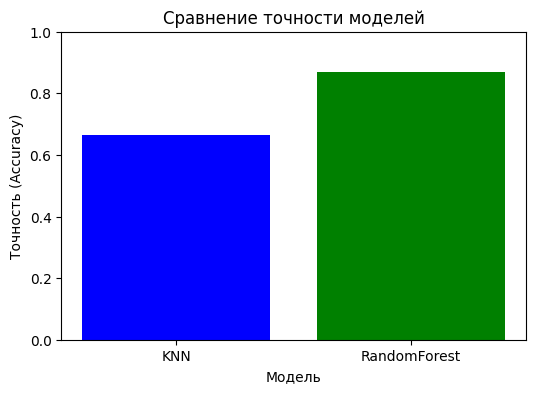

In [139]:
# Столбчатая диаграмма точности
plt.figure(figsize=(6, 4))
plt.bar(["KNN", "RandomForest"], [accuracy_KNN, accuracy_RFC], color=['blue', 'green'])
plt.xlabel("Модель")
plt.ylabel("Точность (Accuracy)")
plt.title("Сравнение точности моделей")
plt.ylim(0, 1)
plt.show()

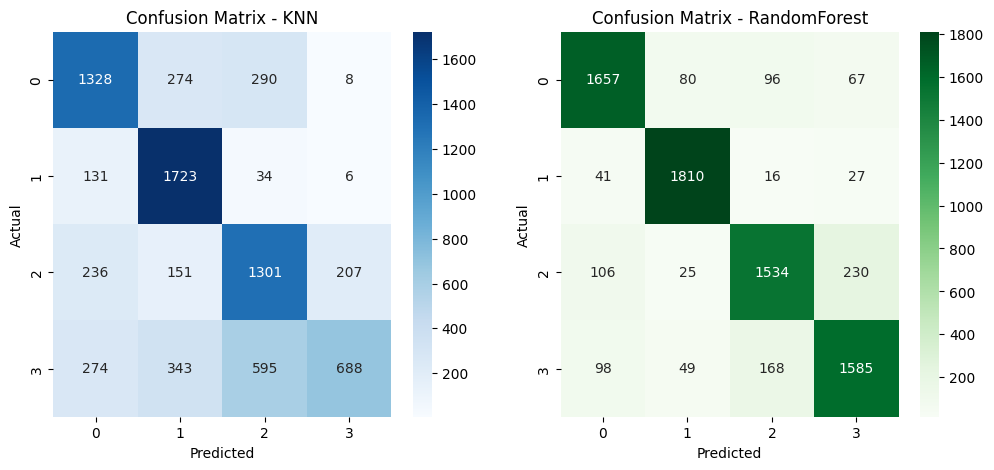

In [140]:
# Матрица ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_KNN = confusion_matrix(y_test, y_pred_KNN)
cm_RFC = confusion_matrix(y_test, y_pred_RFC)

sns.heatmap(cm_KNN, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - KNN")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_RFC, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Confusion Matrix - RandomForest")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()

/var/folders/25/w1m7j6bd3812vprs493536cm0000gn/T/ipykernel_5639/3285559084.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(classes, rotation=45)
/var/folders/25/w1m7j6bd3812vprs493536cm0000gn/T/ipykernel_5639/3285559084.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(classes, rotation=45)
/var/folders/25/w1m7j6bd3812vprs493536cm0000gn/T/ipykernel_5639/3285559084.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(classes, rotation=45)


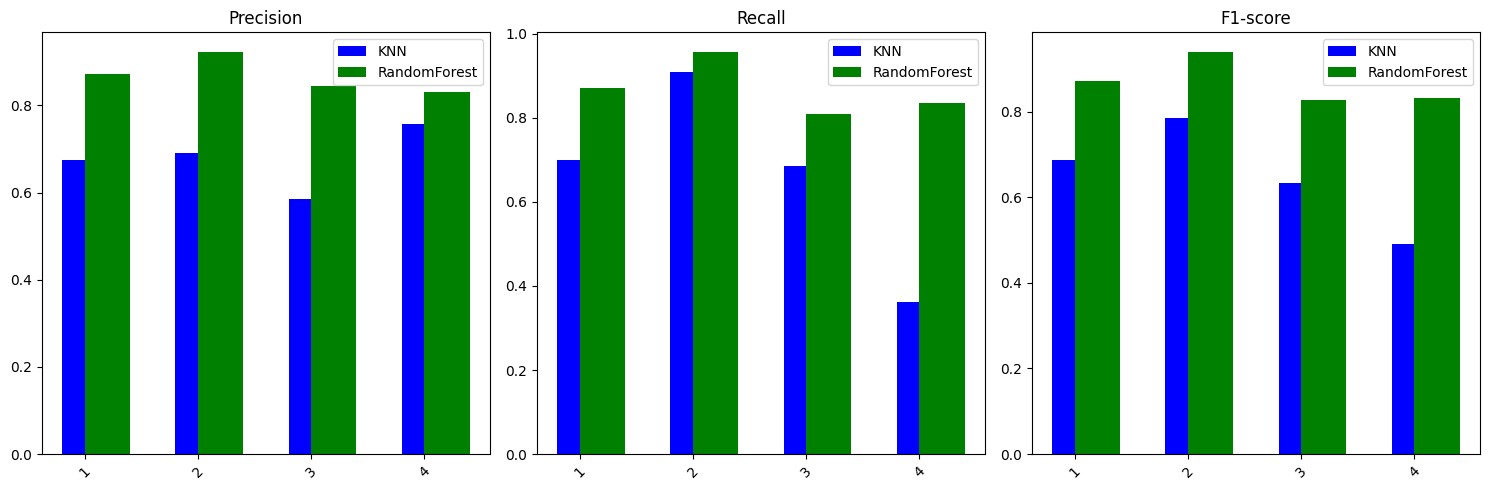

In [141]:
# Сравнение Precision, Recall, F1-score
report_KNN = classification_report(y_test, y_pred_KNN, output_dict=True)
report_RFC = classification_report(y_test, y_pred_RFC, output_dict=True)

metrics = ["precision", "recall", "f1-score"]
classes = list(report_KNN.keys())[:-3]  # Убираем avg/total строки

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    knn_values = [report_KNN[c][metric] for c in classes]
    rfc_values = [report_RFC[c][metric] for c in classes]
    
    axes[i].bar(classes, knn_values, width=0.4, label="KNN", color='blue', align='center')
    axes[i].bar(classes, rfc_values, width=0.4, label="RandomForest", color='green', align='edge')
    
    axes[i].set_title(metric.capitalize())
    axes[i].set_xticklabels(classes, rotation=45)
    axes[i].legend()

plt.tight_layout()
plt.show()